In [5]:
import os
from tensorflow import keras
import numpy as np
import cv2
from imgaug import augmenters as iaa
import json
import copy
import matplotlib.pyplot as plt
import random

DATA_PATH = './data/GeneratorData/'
IMAGES_EXT = ['.jpg', '.png']
DATASET_SHAPE = (64, 64)


def list_files(d, ext_list):
    if not os.path.exists(d) or not os.listdir(d):
        return tuple()
    return filter(lambda x: os.path.isfile(os.path.join(d, x))
                            and os.path.splitext(x)[1].lower() in ext_list, os.listdir(d))


def get_dewarped_patch(img, pols, shape=(64, 64)):
    # Crops a polygon (namely, a rectangle containing a bubble) with given vertices from an image'
    assert len(img.shape) == 2, "Make sure that the image is in greyscale"
    source = np.float32([pols[0], pols[1], pols[3]])
    destination = np.float32([[0, 0], [shape[1], 0], [0, shape[0]]])
    # Destination can be with gap:
    m = cv2.getAffineTransform(source, destination)
    dst = cv2.warpAffine(img, m, shape, flags=cv2.INTER_LANCZOS4)
    return dst


def show_images(images, labels):
    img = np.concatenate(images, axis=1).reshape(-1, images[0].shape[1] * len(images))
    fig, ax = plt.subplots(1, figsize=(40, 4))
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.title(str(labels))
    plt.show()


def get_image_data(image_path):

    bubbles = []
    labels = []

    src_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    markup_path_prefix =os.path.splitext(image_path)[0]
    try:
        with open(markup_path_prefix + '_pols.json', 'r') as mf:
            polygons = json.load(mf)

        with open(markup_path_prefix + '_ethalon.json', 'r') as mf:
            pol_labels = json.load(mf)

        return src_image, polygons, pol_labels

    except FileNotFoundError:
        pass

    return src_image, bubbles, labels


sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq1 = iaa.Sequential(
    [
        iaa.SomeOf((2, 5),
           [
               iaa.OneOf([
                   iaa.GaussianBlur((0, 1.0)),
                   iaa.AverageBlur(k=(2, 5)),
               ]),

               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03 * 255)),
               iaa.Add((-10, 10)),
               iaa.Multiply((0.7, 1.3)),
               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
           ],
           random_order=True
        )
    ],
)



seq = iaa.Sequential(
    [
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-15, 15),
            shear=(-8, 8),
            order=[0, 1],
            mode=['reflect']
        )),
    ],
    random_order=True
)


class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, file_names, pattern_augm, client_image_augm, bubble_augm, n_channels=1,
                 batch_size=32, bubbles_num=800, shuffle=True):

        self.batch_size = batch_size
        self.bubbles_num = bubbles_num
        self.pattern_augm = pattern_augm
        self.client_image_augm = client_image_augm
        self.bubble_augm = bubble_augm
        self.file_names = file_names
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.temp_images = np.array([])
        self.images_info = []
        self.parse_big_images()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.file_names * self.bubbles_num) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        if index == 0:
            self.on_epoch_end()

        file_num = (index * self.batch_size) // self.bubbles_num
        pos_in_file = (index * self.batch_size) % self.bubbles_num

        if pos_in_file + self.batch_size > self.bubbles_num:
            pos_in_file = self.bubbles_num - self.batch_size

        x, y = self.__data_generation(self.temp_images[file_num], pos_in_file)
        return x, y, index

    def parse_big_images(self):
        x = []

        for i in range(len(self.file_names)):
            img1, polygons1, labels1 = get_image_data(self.file_names[i][0])
            img2, polygons2, labels2 = get_image_data(self.file_names[i][1])

            x.append([(img1, polygons1, labels1), (img2, polygons2, labels2)])

        self.images_info = x

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        tmp = copy.deepcopy(self.images_info)
        result = []

        for i in range(len(tmp)):
            pair = tmp[i]

            image_base = self.pattern_augm.augment_image(pair[0][0])
            image_client = self.client_image_augm.augment_image(pair[1][0])

            result.append(((image_base, pair[0][1], pair[0][2]), (image_client, pair[1][1], pair[1][2])))
            show_images([image_base, image_client], [0, 0])

        self.temp_images = result

    def __data_generation(self, pair_images, batch_start_position):
        """Generates data containing batch_size samples"""
        x = np.empty((self.batch_size, 2, DATASET_SHAPE[0], DATASET_SHAPE[1], self.n_channels))
        y = np.empty(self.batch_size, dtype=int)

        token = 0
        for j in range(batch_start_position, batch_start_position + self.batch_size):
            curr_pair = np.empty((2, DATASET_SHAPE[0], DATASET_SHAPE[1], self.n_channels))
            for ind in range(0, 2):
                polygon = pair_images[ind][1][j]

                #random bubble shift
                shift_x = random.randrange(-15, 15)
                shift_y = random.randrange(-15, 15)

                polygon = [[point[0] + shift_x, point[1] + shift_y] for point in polygon]


                bubble = get_dewarped_patch(pair_images[ind][0], polygon, DATASET_SHAPE)
                bubble = np.expand_dims(bubble, axis=3)
                bubble = self.bubble_augm.augment_image(bubble)

                curr_pair[ind] = bubble

            # take second images of pair, take label with j-th index
            y[token] = pair_images[1][2][j]
            x[token] = curr_pair

            token += 1

        return x, y


def show_images(images, labels):
    img = np.concatenate(images, axis=1).reshape(-1, images[0].shape[1] * len(images))
    fig, ax = plt.subplots(1, figsize=(40, 4))
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.title(str(labels))
    plt.show()




def parse_dataset(data_path):
    """
    input: path to folder
    output: List of pair client image, pattern image
    """
    pairs = []

    for pattern_file in list_files(data_path, IMAGES_EXT):
        image_path = os.path.join(data_path, pattern_file)
        client_image_folder = os.path.join(data_path, pattern_file.split('.')[0])

        for client_file in list_files(client_image_folder, IMAGES_EXT):
            client_image_path = os.path.join(client_image_folder, client_file)
            pairs.append([image_path, client_image_path])

    return pairs


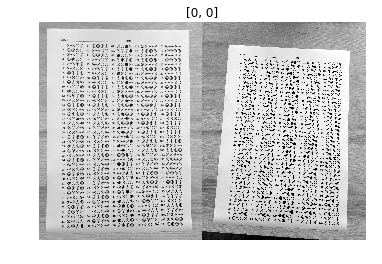

/home/bolivar1997/PycharmProjects/untitled/venv/lib/python3.5/site-packages/ipykernel/__main__.py:183: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


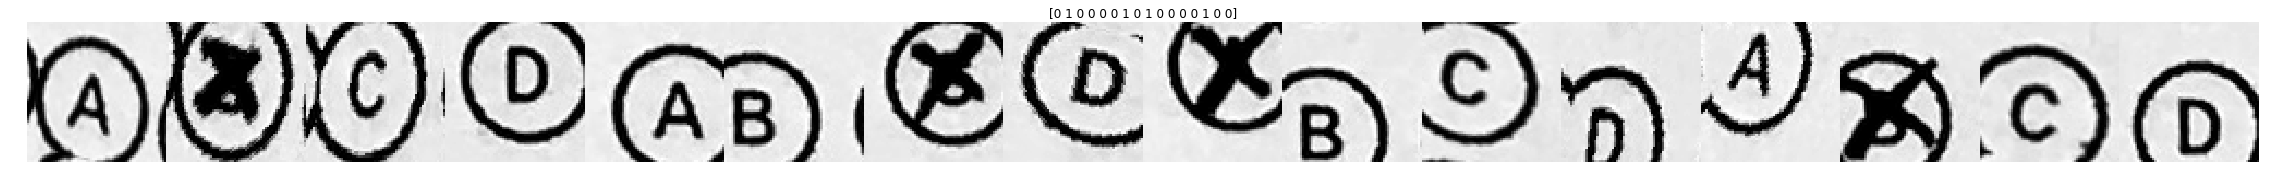

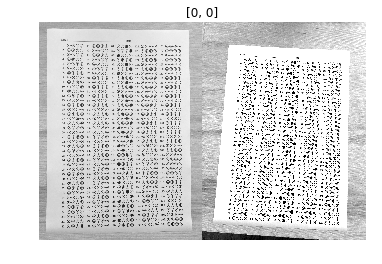

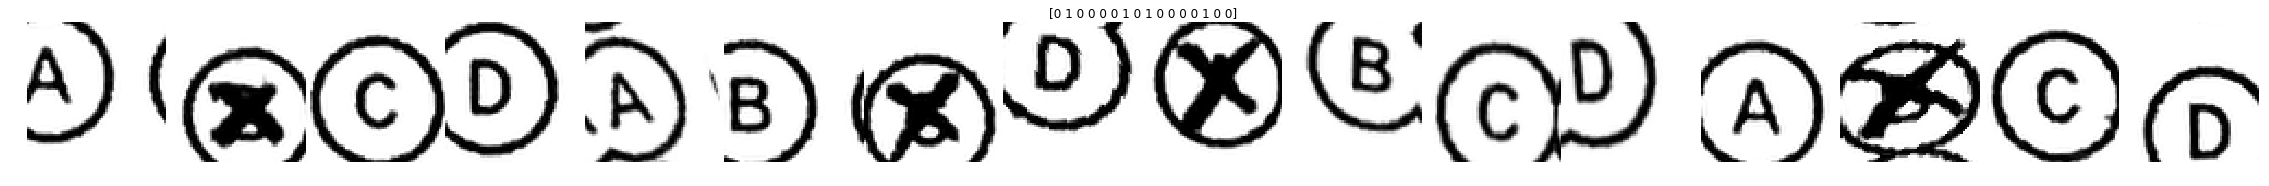

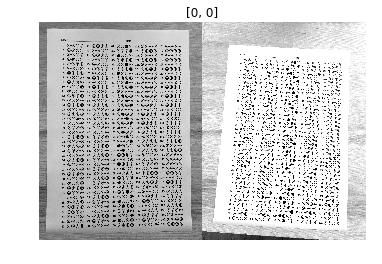

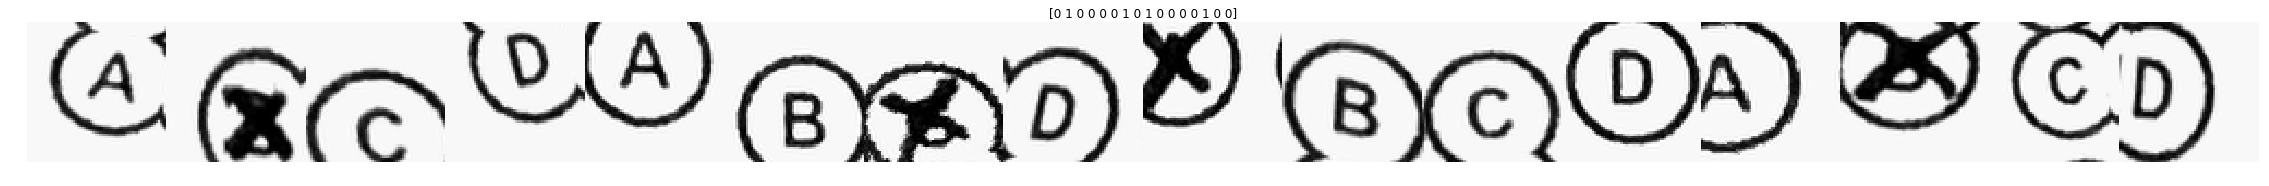

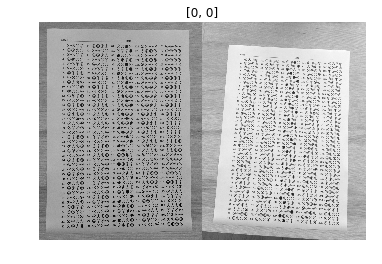

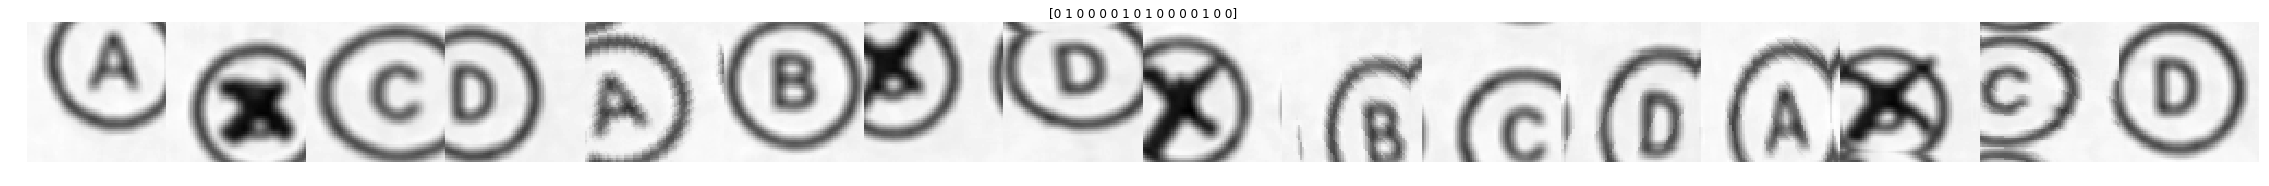

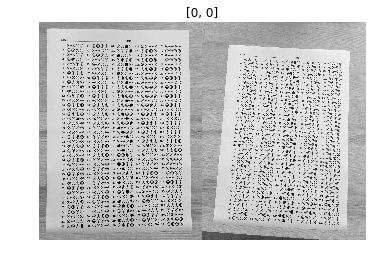

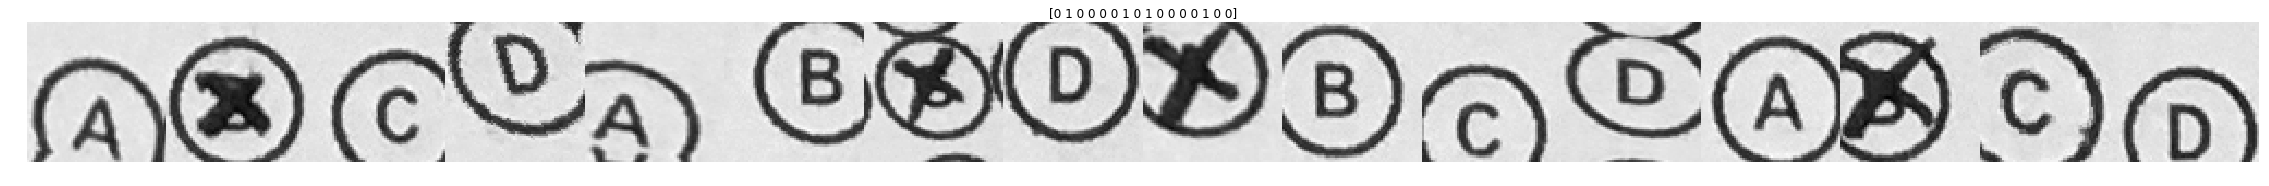

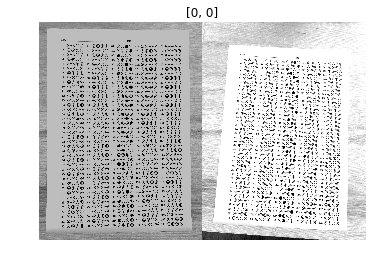

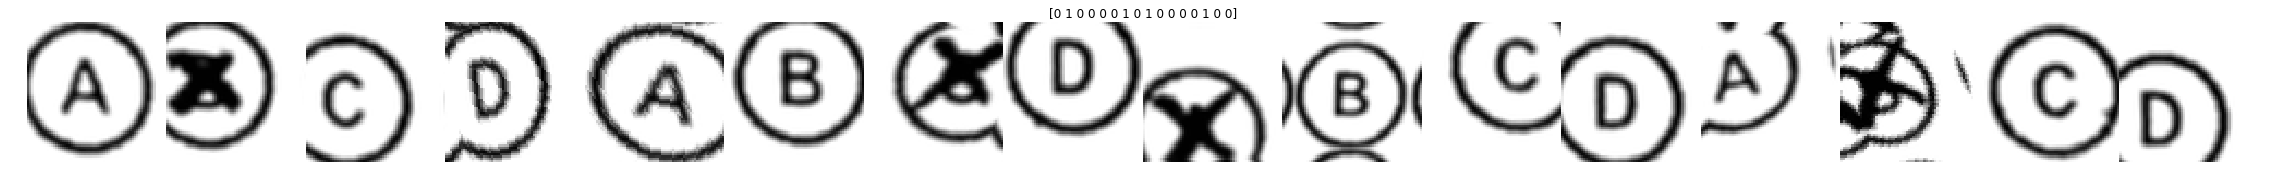

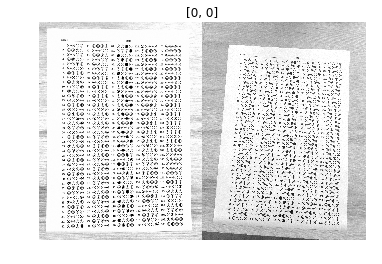

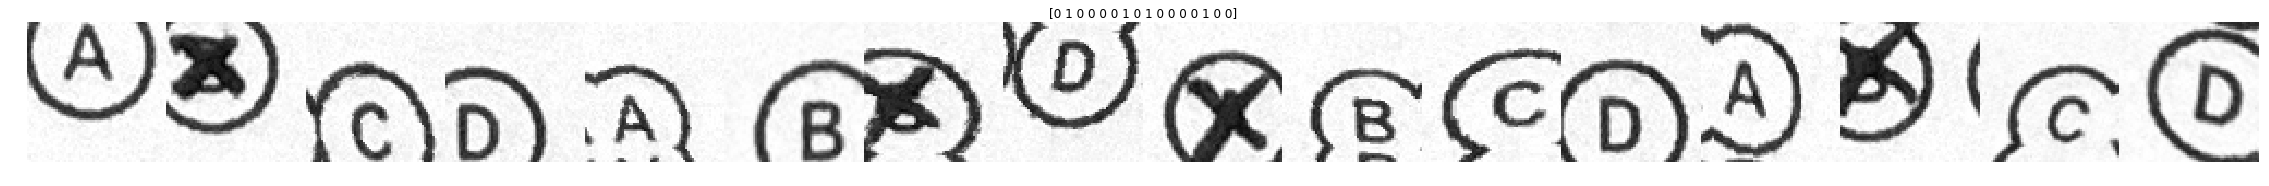

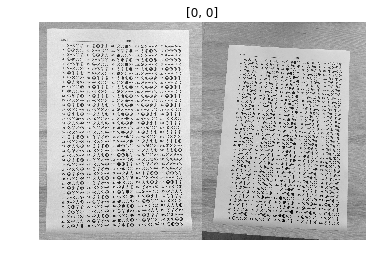

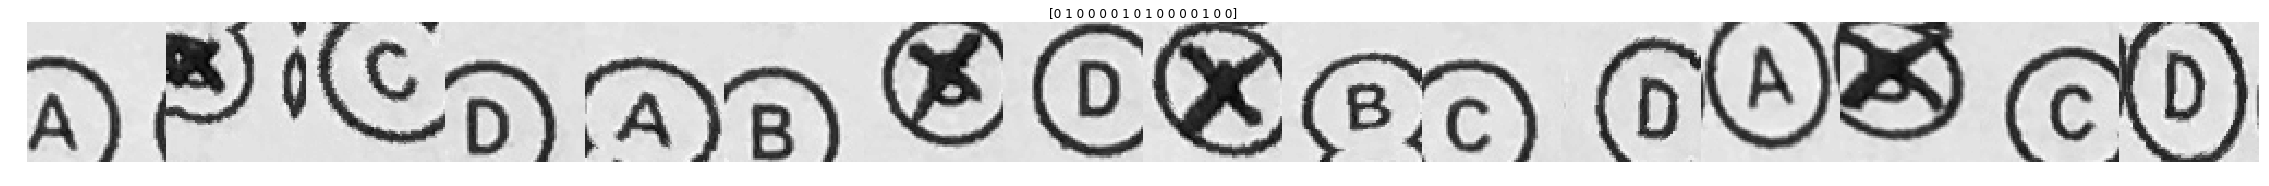

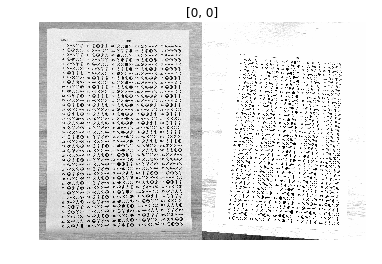

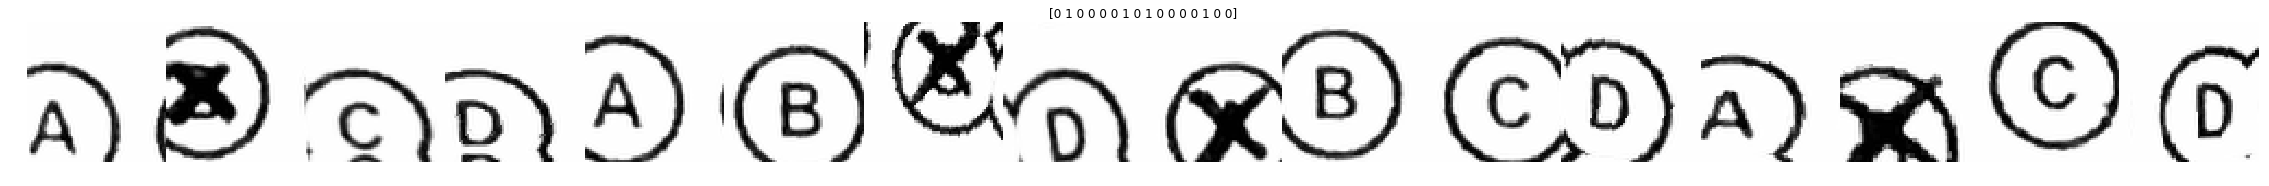

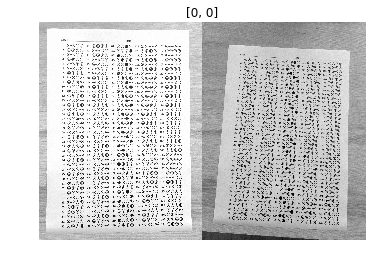

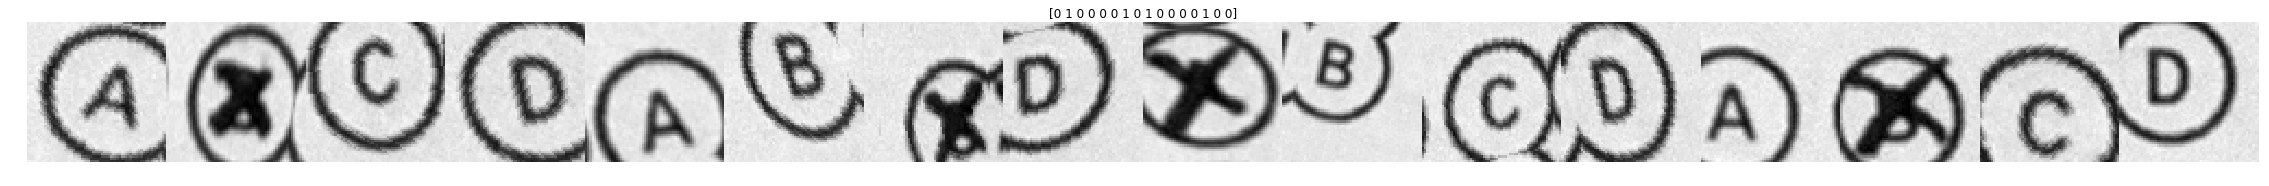

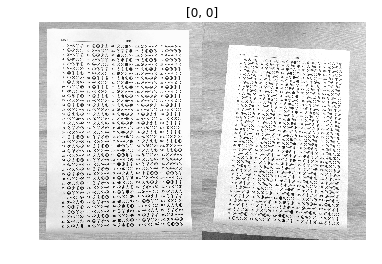

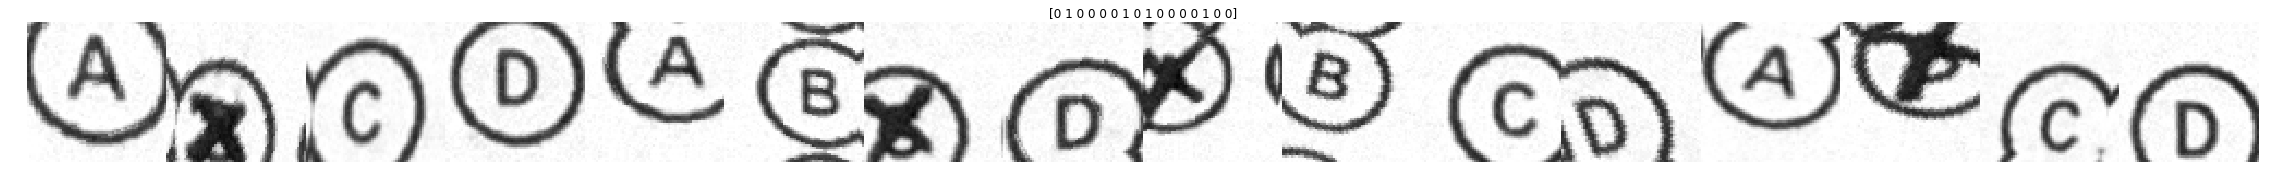

In [7]:
%matplotlib inline
pairs = parse_dataset('./data/GeneratorData')
training_generator = DataGenerator(pairs, seq1, seq1, seq)


token = 0
for x_batch, y_batch, id in training_generator:
    images = x_batch[:, 1, :, :, :]

    if token % 25 == 0:
        show_images(images[:16], y_batch[:16])
    token += 1

    if token > 250:
        break